# RNN Implementation and Experiments

This notebook demonstrates the RNN implementation and experiments. We'll work with the NusaX-Sentiment dataset to perform text classification.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append('../..')

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense, Bidirectional
from sklearn.metrics import f1_score, classification_report

2025-05-30 22:01:00.779083: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748617260.890500    2052 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748617260.924008    2052 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748617261.185247    2052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748617261.185284    2052 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748617261.185286    2052 computation_placer.cc:177] computation placer alr

In [3]:
from src.models.src.models.base_model.utils.nusax_loader import NusaXLoader
from src.models.src.models.rnn.experiment import RNNExperiments
from src.models.src.models.rnn.rnn_model import RNNModel
from src.models.src.models.rnn.rnn_layer import RNNLayer
from src.models.src.models.base_model.layers.embedding_layer import EmbeddingLayer
from src.models.src.models.base_model.layers.dense_layer import DenseLayer
from src.models.src.models.base_model.layers.dropout_layer import DropoutLayer
from src.models.src.models.base_model.layers.activation_layer import Softmax
from src.models.src.models.base_model.utils.evaluation import compare_keras_vs_scratch
from src.models.src.models.base_model.utils.visualization import plot_training_history

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(f"Num GPUs Available: {len(gpus)}")
        print(f"Num Logical GPUs: {len(logical_gpus)}")
    except RuntimeError as e:
        print(e)


Num GPUs Available: 1
Num Logical GPUs: 1


I0000 00:00:1748617265.380299    2052 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


## 1. Load Data

In [5]:
# Init data loader
data_loader = NusaXLoader(batch_size=32, add=True)
# Ini add buat ngubah pathnya nambah "../" tapi harusnya gaperlu soalnya di file siblingnsnya juga gapake ini, api entah kenapa gabisa jalan kalo gadipasang

# Train
train_dataset = data_loader.get_dataset('train')
for tokens, labels in train_dataset.take(1):
    sample_tokens = tokens.numpy()
    sample_labels = labels.numpy()
    break

# Get vocabulary
vocab = data_loader.get_vocabulary()
print(f"Vocabulary size: {len(vocab)}")
print(f"First 20 words in vocabulary: {vocab[:20]}")

# Output Example
print("\nSample texts:")
for i in range(3):
    # Convert token IDs back to words
    words = [vocab[idx] if idx < len(vocab) else "[UNK]" for idx in sample_tokens[i] if idx > 0]
    text = " ".join(words)
    print(f"Text {i+1}: {text}")
    print(f"Label: {sample_labels[i]}\n")

Vocabulary size: 2836
First 20 words in vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini'), np.str_('makan'), np.str_('untuk'), np.str_('ke'), np.str_('tempat'), np.str_('makanan'), np.str_('juga'), np.str_('sangat'), np.str_('ada'), np.str_('banyak'), np.str_('karena')]

Sample texts:
Text 1: nikmati cicilan 0 hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni
Label: 1

Text 2: kuekue yang disajikan bikin saya bernostalgia semuanya tipikal kue zaman dulu baik dari penampilan maupun rasa kuenya enak dan harganya juga murah
Label: 2

Text 3: ibu pernah bekerja di grab indonesia
Label: 1



## 2. Hyperparameter Experiments with RNN

In [6]:
experiments = RNNExperiments(data_loader=data_loader, batch_size=32, epochs=10, embedding_dim=100)

Vocabulary size: 2836
Number of classes: 3
Maximum sequence length: 100
Batch size: 32
Epochs: 10
Embedding dimension: 100


### 2.1 Experiment: Number of RNN Layers


=== Training model with 1 RNN Layer ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
I0000 00:00:1748617267.733233    2721 service.cc:152] XLA service 0x74787c05ab30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748617267.733272    2721 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-05-30 22:01:07.801444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748617268.022500    2721 cuda_dnn.cc:529] Loaded cuDNN version 90300


 7/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3143 - loss: 1.1328

I0000 00:00:1748617269.453147    2721 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 156ms/step - accuracy: 0.3597 - loss: 1.1099 - val_accuracy: 0.4300 - val_loss: 1.0706
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5470 - loss: 0.9495 - val_accuracy: 0.4700 - val_loss: 1.0301
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5658 - loss: 0.8801 - val_accuracy: 0.5500 - val_loss: 0.9630
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6387 - loss: 0.7429 - val_accuracy: 0.3700 - val_loss: 1.1926
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5688 - loss: 0.8721 - val_accuracy: 0.5200 - val_loss: 1.0644
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4064 - loss: 1.1743 - val_accuracy: 0.5100 - val_loss: 0.9773
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7017 - loss: 0.7097 - val_accuracy: 0.4000 - val_loss: 1.3571
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6397 - loss: 0.7932 - val_accuracy: 0.4500 - val_loss: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 2 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - accuracy: 0.3782 - loss: 1.1496 - val_accuracy: 0.3900 - val_loss: 1.0996
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4378 - loss: 1.0381 - val_accuracy: 0.4600 - val_loss: 1.1287
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.7568 - loss: 0.6192 - val_accuracy: 0.3700 - val_loss: 1.3662
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8681 - loss: 0.4047 - val_accuracy: 0.3900 - val_loss: 1.7464
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8955 - loss: 0.3348 - val_accuracy: 0.3800 - val_loss: 1.5983
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8690 - loss: 0.3539 - val_accuracy: 0.3700 - val_loss: 1.9817
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9180 - loss: 0.2155 - val_accuracy: 0.3800 - val_loss: 2.2477
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9648 - loss: 0.1095 - val_accuracy: 0.3300 - val_loss: 2

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,835 (3.46 MB)

 Trainable params: 302,611 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 605,224 (2.31 MB)


=== Training model with 3 RNN Layers ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.3924 - loss: 1.2085 - val_accuracy: 0.3800 - val_loss: 1.1219
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.3264 - loss: 1.2231 - val_accuracy: 0.3800 - val_loss: 1.1122
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3839 - loss: 1.1895 - val_accuracy: 0.3800 - val_loss: 1.0961
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.3569 - loss: 1.2216 - val_accuracy: 0.3800 - val_loss: 1.0840
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3470 - loss: 1.1820 - val_accuracy: 0.3800 - val_loss: 1.0923
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3111 - loss: 1.1958 - val_accuracy: 0.3800 - val_loss: 1.0859
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.3151 - loss: 1.1679 - val_accuracy: 0.3800 - val_loss: 1.0902
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.3350 - loss: 1.1766 - val_accuracy: 0.3800 - val_loss: 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 100, 64)        │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 932,603 (3.56 MB)

 Trainable params: 310,867 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 621,736 (2.37 MB)

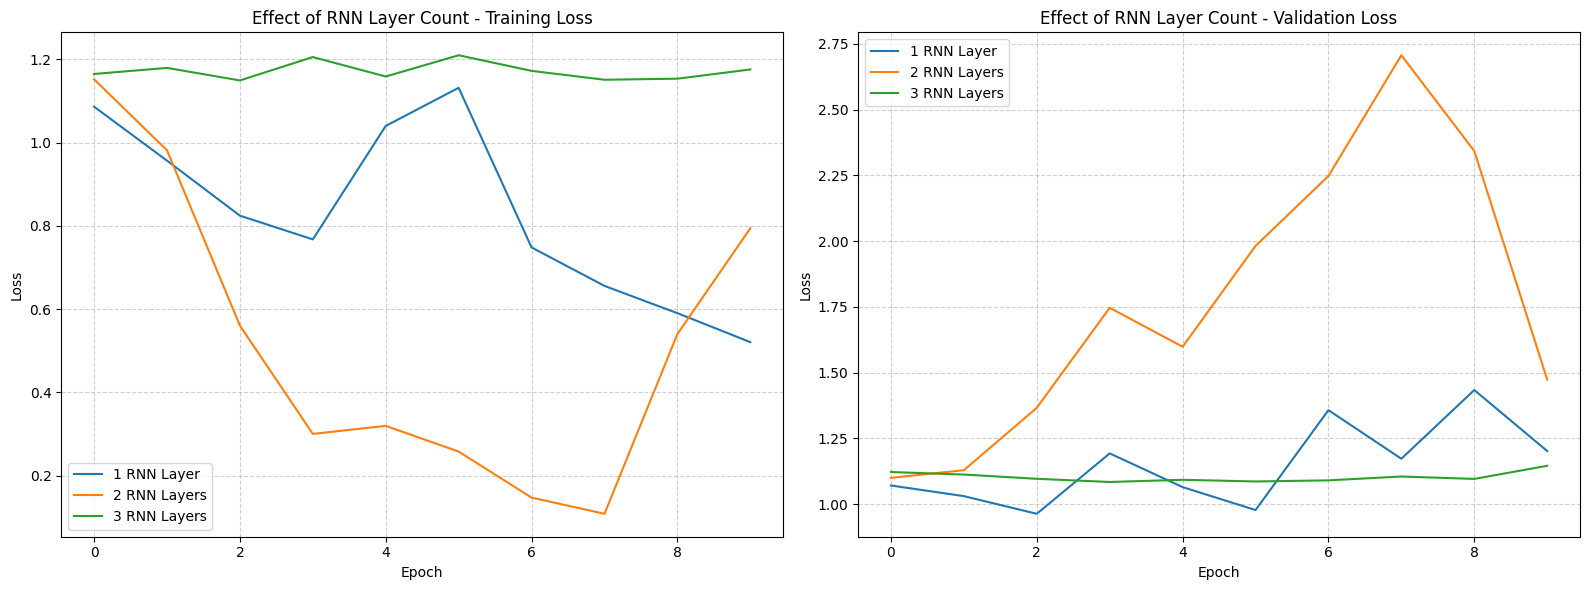

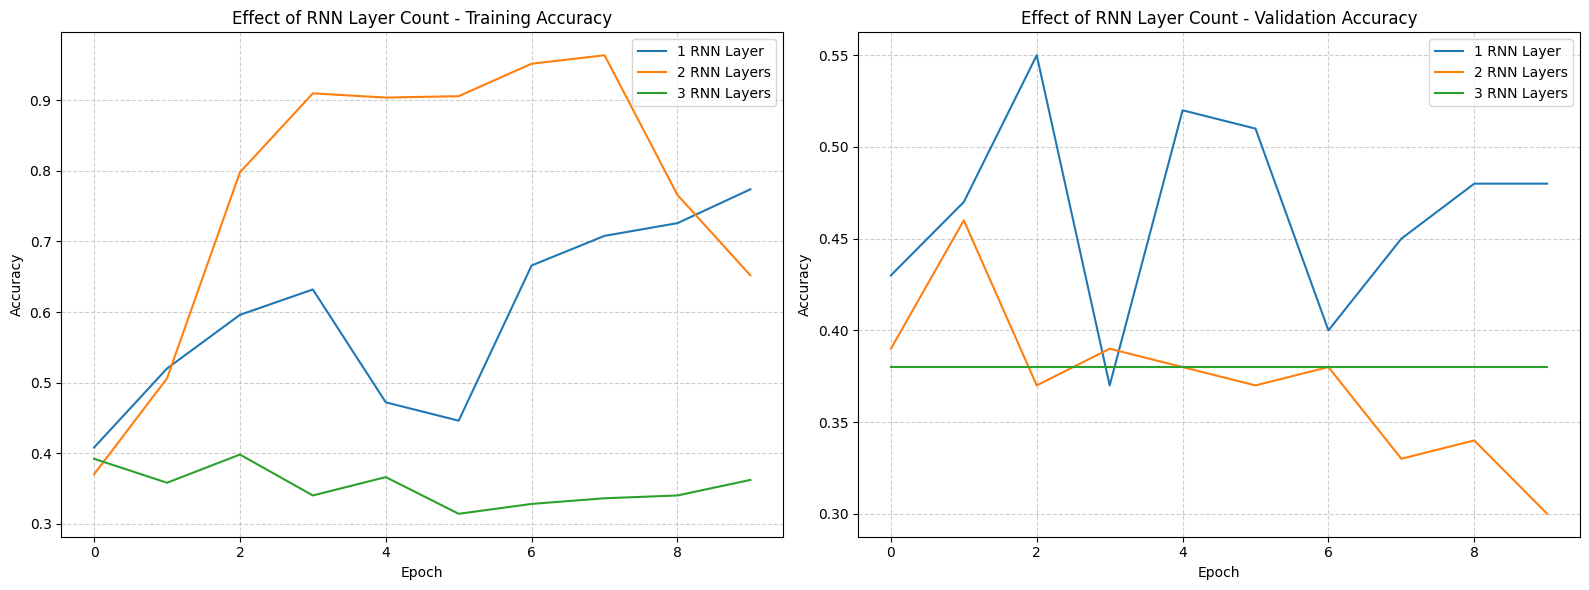

In [7]:
layer_count_variants = [
    (1, "1 RNN Layer"),
    (2, "2 RNN Layers"),
    (3, "3 RNN Layers")
]

# Run experiment
layer_count_models, layer_count_histories = experiments.run_layer_count_experiment(layer_count_variants)

### 2.2 Experiment: Number of RNN Cells per Layer


=== Training model with 32 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 0.3488 - loss: 1.1020 - val_accuracy: 0.3800 - val_loss: 1.0763
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5204 - loss: 0.9949 - val_accuracy: 0.3300 - val_loss: 1.1161
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7997 - loss: 0.7487 - val_accuracy: 0.2900 - val_loss: 1.2437
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5500 - loss: 0.9144 - val_accuracy: 0.3900 - val_loss: 1.2157
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5423 - loss: 0.9683 - val_accuracy: 0.3800 - val_loss: 1.1396
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5080 - loss: 0.9527 - val_accuracy: 0.3600 - val_loss: 1.1015
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6031 - loss: 0.8562 - val_accuracy: 0.4100 - val_loss: 1.1287
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6614 - loss: 0.8291 - val_accuracy: 0.4200 - val_loss: 1

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)


=== Training model with 64 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.3354 - loss: 1.1359 - val_accuracy: 0.5200 - val_loss: 1.0451
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6286 - loss: 0.9064 - val_accuracy: 0.5200 - val_loss: 1.0254
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8572 - loss: 0.6148 - val_accuracy: 0.3600 - val_loss: 1.1923
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7329 - loss: 0.6420 - val_accuracy: 0.3400 - val_loss: 1.2574
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5907 - loss: 0.8795 - val_accuracy: 0.4100 - val_loss: 1.3043
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5268 - loss: 1.0014 - val_accuracy: 0.4400 - val_loss: 1.2164
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4414 - loss: 1.1988 - val_accuracy: 0.3400 - val_loss: 1.3208
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 207ms/step - accuracy: 0.3090 - loss: 1.3608 - val_accuracy: 0.3700 - val_loss: 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,067 (3.37 MB)

 Trainable params: 294,355 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 588,712 (2.25 MB)


=== Training model with 128 Units ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.3816 - loss: 1.1245 - val_accuracy: 0.3800 - val_loss: 1.1401
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3222 - loss: 1.1442 - val_accuracy: 0.3400 - val_loss: 1.1342
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3994 - loss: 1.1105 - val_accuracy: 0.4100 - val_loss: 1.0577
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5154 - loss: 0.9696 - val_accuracy: 0.2700 - val_loss: 1.2799
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4478 - loss: 1.0480 - val_accuracy: 0.2600 - val_loss: 1.2537
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2730 - loss: 1.2563 - val_accuracy: 0.4200 - val_loss: 1.2184
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5541 - loss: 0.9943 - val_accuracy: 0.3400 - val_loss: 1.2621
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4096 - loss: 1.1653 - val_accuracy: 0.3600 - val_loss: 1

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

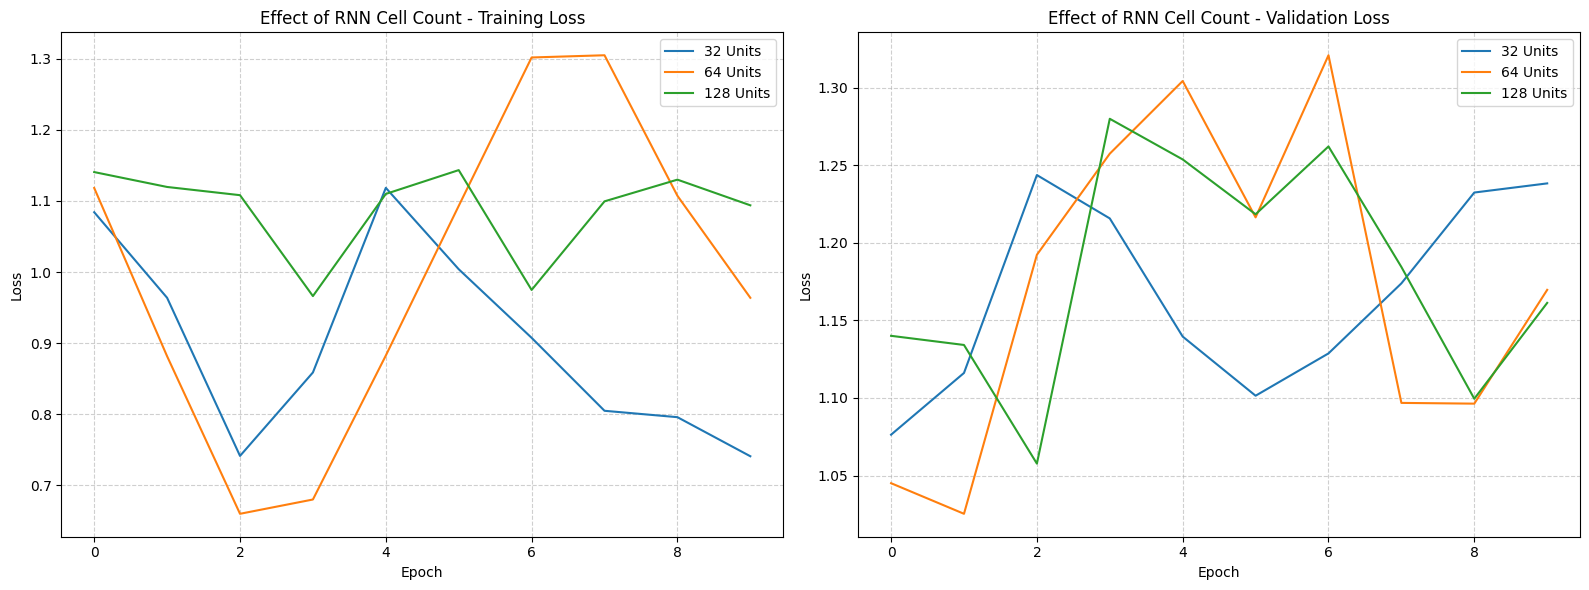

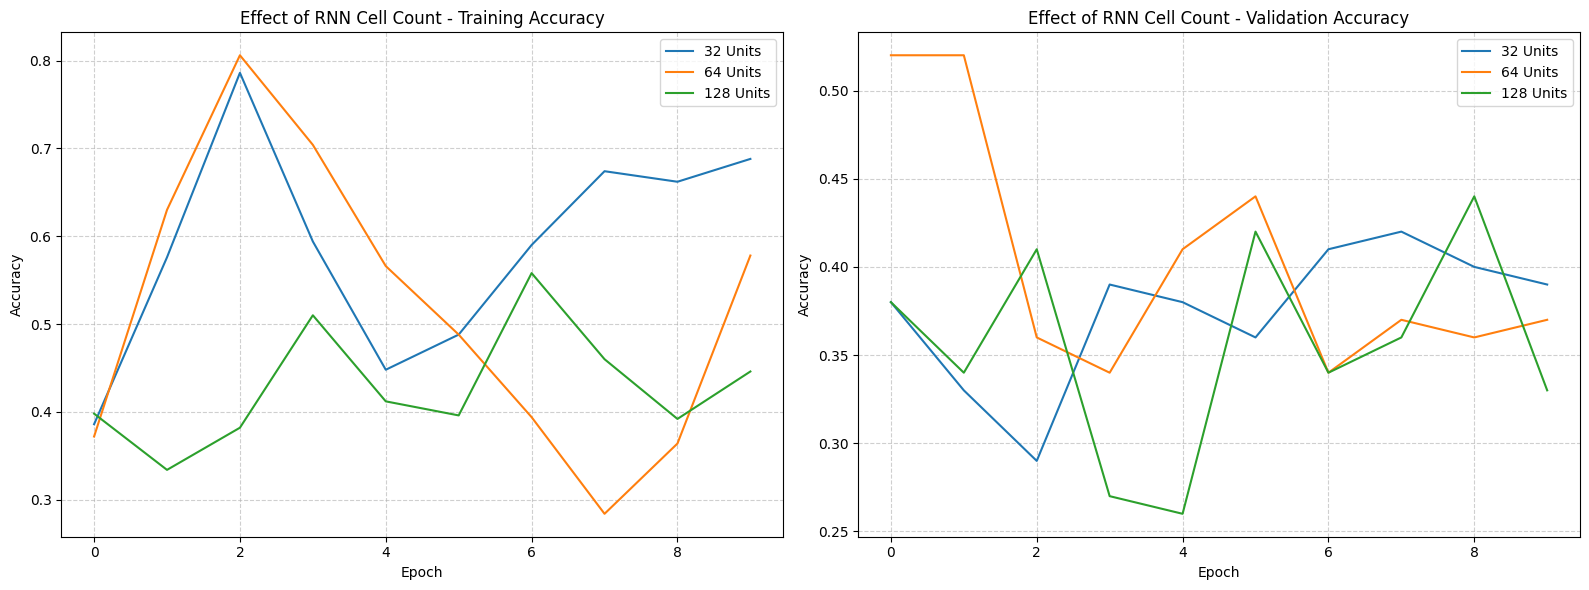

In [8]:
# Define variants for cell counts
cell_count_variants = [
    ([32], "32 Units"),
    ([64], "64 Units"),
    ([128], "128 Units")
]

# Run experiment
cell_count_models, cell_count_histories = experiments.run_cell_count_experiment(cell_count_variants)

### 2.3 Experiment: RNN Direction


=== Training model with Unidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.3888 - loss: 1.1041 - val_accuracy: 0.3700 - val_loss: 1.0748
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5379 - loss: 0.9897 - val_accuracy: 0.3700 - val_loss: 1.2087
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3594 - loss: 1.1744 - val_accuracy: 0.2600 - val_loss: 1.3174
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5546 - loss: 0.9936 - val_accuracy: 0.3500 - val_loss: 1.2219
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4368 - loss: 1.1533 - val_accuracy: 0.3800 - val_loss: 1.0995
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4191 - loss: 1.0870 - val_accuracy: 0.3900 - val_loss: 1.0802
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4363 - loss: 1.0741 - val_accuracy: 0.3800 - val_loss: 1.0844
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3982 - loss: 1.1298 - val_accuracy: 0.3500 - val_loss: 1

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)


=== Training model with Bidirectional RNN RNN ===
Epoch 1/10


/root/ML/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.3818 - loss: 1.0896 - val_accuracy: 0.4900 - val_loss: 1.0160
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ -7s -452495us/step - accuracy: 0.6551 - loss: 0.8468 - val_accuracy: 0.5400 - val_loss: 0.9677
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step - accuracy: 0.8754 - loss: 0.5410 - val_accuracy: 0.5200 - val_loss: 0.9609
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9563 - loss: 0.2826 - val_accuracy: 0.5200 - val_loss: 1.0071
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9743 - loss: 0.1329 - val_accuracy: 0.4800 - val_loss: 1.0826
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9865 - loss: 0.0656 - val_accuracy: 0.5300 - val_loss: 1.0286
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.9984 - loss: 0.0398 - val_accuracy: 0.4800 - val_loss: 1.1475
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 1.0000 - loss: 0.0221 - val_accuracy: 0.5700 - val

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │        58,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,028,987 (3.93 MB)

 Trainable params: 342,995 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 685,992 (2.62 MB)

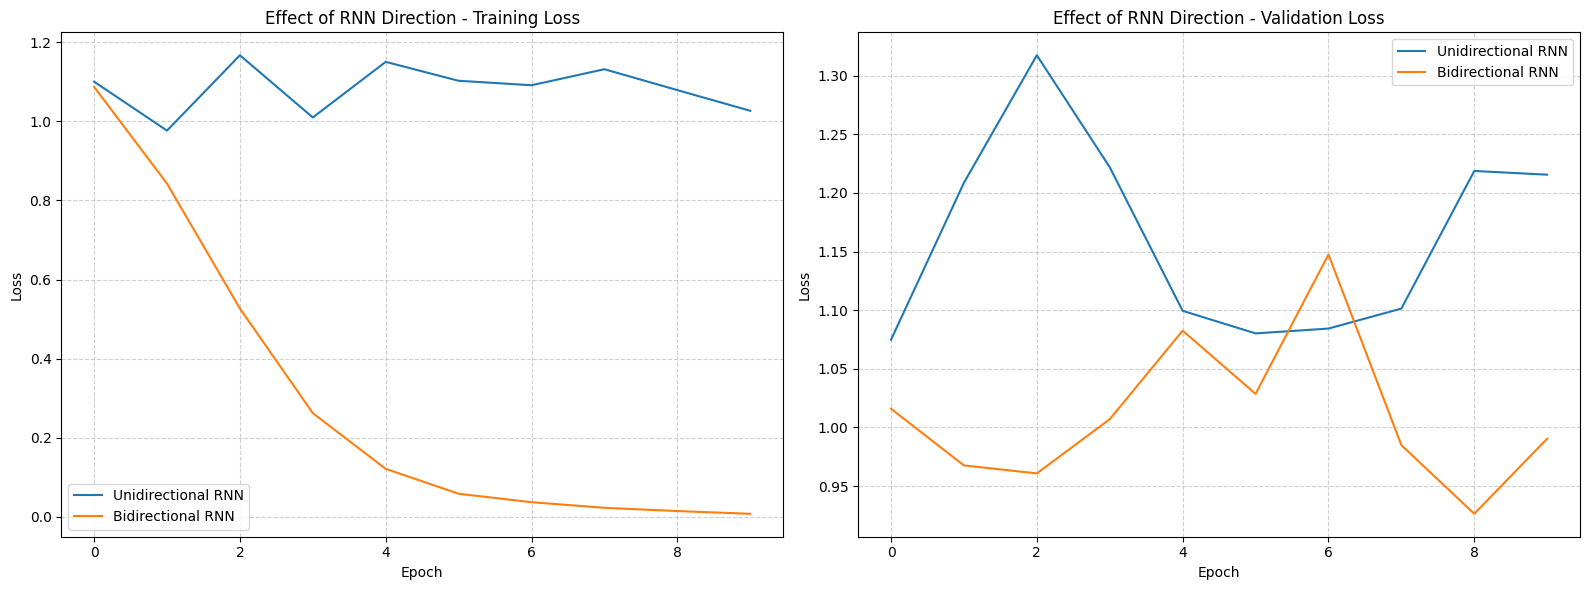

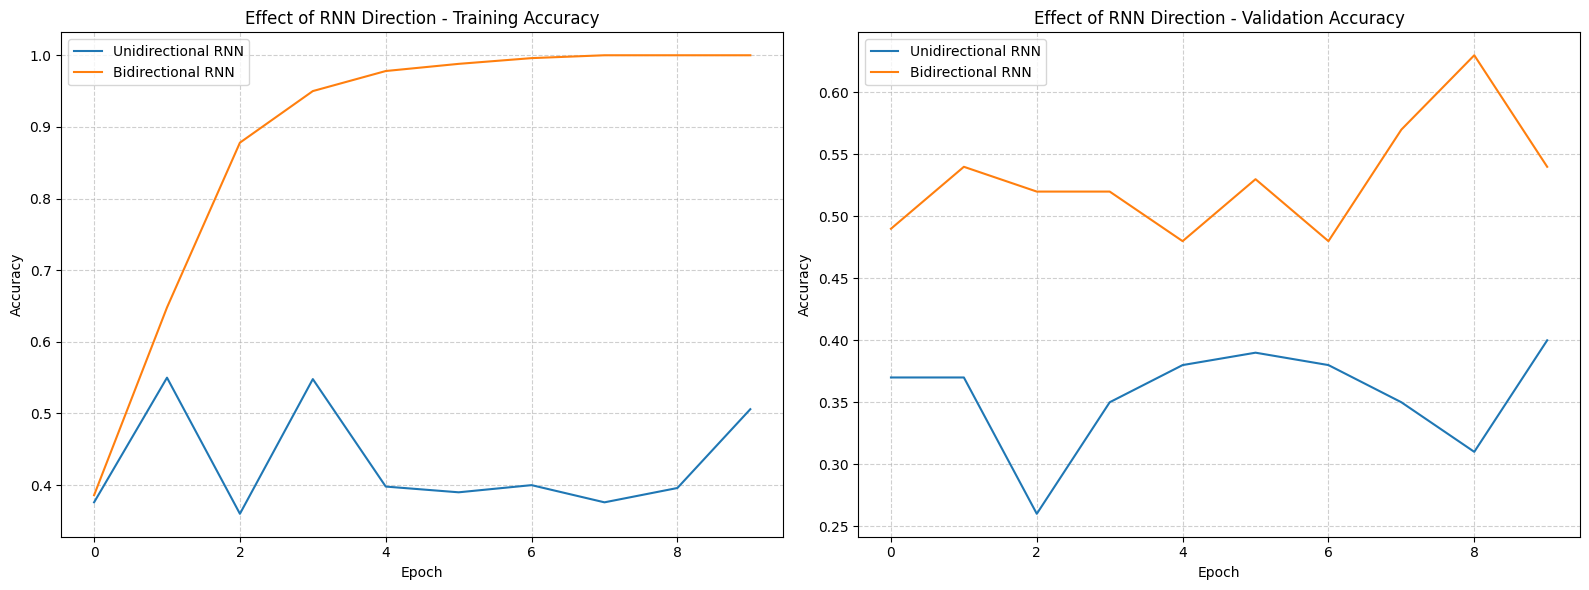

In [9]:
# Define variants for RNN direction
direction_variants = [
    (False, "Unidirectional RNN"),
    (True, "Bidirectional RNN")
]

# Run experiment
direction_models, direction_histories = experiments.run_direction_experiment(direction_variants)

## 3. From-Scratch RNN Implementation

### Unidirectional

In [10]:
keras_model_unidirectional = "../output/models/rnn/rnn_unidirectional.keras"
result_unidirectional = experiments.compare_models_simple(keras_model_unidirectional)

Loaded Keras model from ../output/models/rnn/rnn_unidirectional.keras


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,899 (3.59 MB)

 Trainable params: 313,299 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 626,600 (2.39 MB)

Keras model has 4 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 128 (return_sequences=False)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: Dense
Added Dense layer with Softmax: 128 → 3

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: DenseLayer
Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 4 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 128), U: (128, 128), b: (128,)
Successfully loaded weights for layer 1

Loading weights for layer 2:
Successful

In [14]:
print("=== Model Comparison Unidirectional Result ===")
print(f"Keras Accuracy       : {result_unidirectional['keras_metrics']['accuracy']:.4f}")
print(f"Keras Macro F1       : {result_unidirectional['keras_metrics']['macro_f1']:.4f}")
print(f"Scratch Accuracy     : {result_unidirectional['scratch_metrics']['accuracy']:.4f}")
print(f"Scratch Macro F1     : {result_unidirectional['scratch_metrics']['macro_f1']:.4f}")
print(f"Model Agreement      : {result_unidirectional['model_agreement']:.4f}")


=== Model Comparison Unidirectional Result ===
Keras Accuracy       : 0.4050
Keras Macro F1       : 0.3259
Scratch Accuracy     : 0.4050
Scratch Macro F1     : 0.3259
Model Agreement      : 1.0000


### Bidirectional

In [12]:
keras_model_bidirectional = "../output/models/rnn/rnn_cells_32.keras"
result_bidirectional = experiments.compare_models_simple(keras_model_bidirectional)

Loaded Keras model from ../output/models/rnn/rnn_cells_32.keras


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       283,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 32)             │         4,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 863,867 (3.30 MB)

 Trainable params: 287,955 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 575,912 (2.20 MB)

Keras model has 4 layers
Processing layer 0: Embedding
Added Embedding layer: 2836 → 100
Processing layer 1: SimpleRNN
Added RNN layer: 100 → 32 (return_sequences=False)
Processing layer 2: Dropout
Added Dropout layer: rate=0.2
Processing layer 3: Dense
Added Dense layer with Softmax: 32 → 3

Scratch model structure:
Layer 0: EmbeddingLayer
Layer 1: RNNLayer
Layer 2: DropoutLayer
Layer 3: DenseLayer
Loading weights from Keras model...
Keras model has 4 layers
Scratch model has 4 layers

Keras model architecture:
  Layer 0: Embedding -> Unknown
  Layer 1: SimpleRNN -> Unknown
  Layer 2: Dropout -> Unknown
  Layer 3: Dense -> Unknown

Scratch model architecture:
  Layer 0: EmbeddingLayer
  Layer 1: RNNLayer
  Layer 2: DropoutLayer
  Layer 3: DenseLayer

Loading weights for layer 0:
Successfully loaded weights for layer 0

Loading weights for layer 1:
Loaded weights - W: (100, 32), U: (32, 32), b: (32,)
Successfully loaded weights for layer 1

Loading weights for layer 2:
Successfully loa

In [15]:
print("=== Model Comparison Bidirectional Result ===")
print(f"Keras Accuracy       : {result_bidirectional['keras_metrics']['accuracy']:.4f}")
print(f"Keras Macro F1       : {result_bidirectional['keras_metrics']['macro_f1']:.4f}")
print(f"Scratch Accuracy     : {result_bidirectional['scratch_metrics']['accuracy']:.4f}")
print(f"Scratch Macro F1     : {result_bidirectional['scratch_metrics']['macro_f1']:.4f}")
print(f"Model Agreement      : {result_bidirectional['model_agreement']:.4f}")


=== Model Comparison Bidirectional Result ===
Keras Accuracy       : 0.4050
Keras Macro F1       : 0.3666
Scratch Accuracy     : 0.4050
Scratch Macro F1     : 0.3666
Model Agreement      : 1.0000
